<b> Цель проекта: </b> выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости


<b> Файл: </b>  данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах

<b> План работы: </b>
1. Выполнить предобработку данных
2. Добавление новых столбцев
3. Исследовательский анализ данных
4. Общий вывод


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv('C:/Users/belle/OneDrive/Документы/датасеты/real_estate_data.csv', sep ='\t')
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')

# Анализ рынка недвижимости в Санкт-Петербруге

## Обзор данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

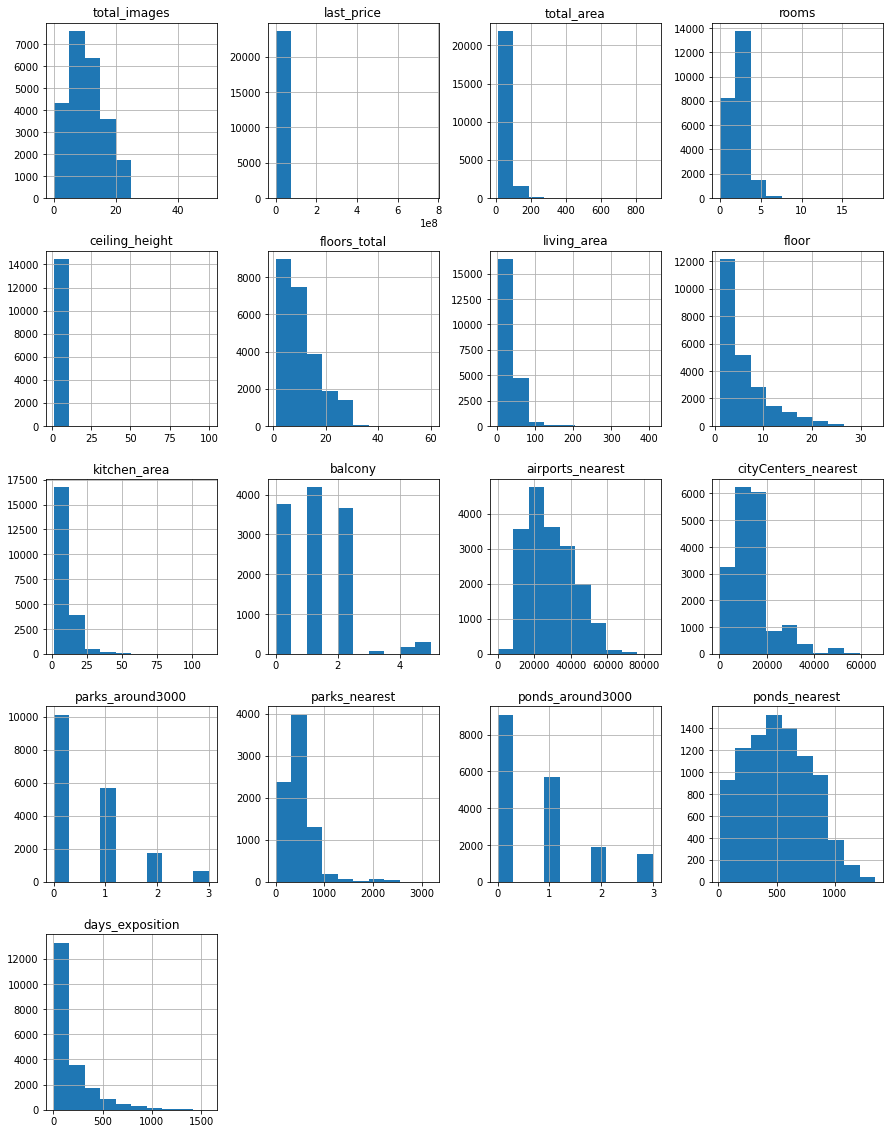

In [5]:
df.hist(figsize=(15, 20))

<AxesSubplot:>

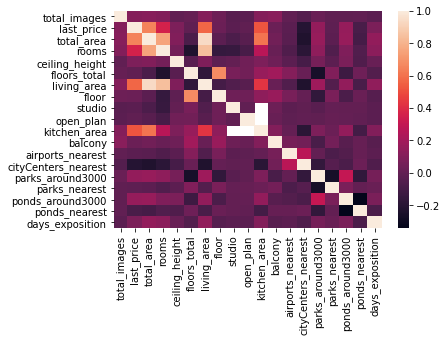

In [6]:
sns.heatmap(df.corr())

## Предобработка данных

### Определим в каких столбцах есть пропуски и заполним пропущенные значения

In [7]:
df.isna().sum() #найдем столбцы с пропусками

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в `balcony` заменим на 0 (так как вероятнее всего их и нет)

In [8]:
df['balcony'] = df['balcony'].fillna(0) #заполним нулями столбец с числом балконов

Строки, в которых пропущены `locality_name` удалим (теряется смысл объявления)

In [9]:
df = df.dropna(subset = ['locality_name'])  #удалим строки, в которых в стобце названия населенного пункта пропуски

Пропущенные значения в `is_apartment` заменим на False(это вероятнее всего)

In [10]:
df['is_apartment'] = df['is_apartment'].fillna(False) #отсутствующие значение в столбце заполним False, так как скорее всего это не апартаменты

В `floors_total` и `ceiling_height` если известна медиана по населенному пункту, то заполним ей. Если не известно, то общей медианой

In [11]:
place_and_floor_median = df.groupby('locality_name')['floors_total'].median()
floors_total_median = df['floors_total'].median()
for e in df[df['floors_total'].isna()]['locality_name'].unique(): #пропущенные этажи заполню медианой по населнному пункту
    try:
        df.loc[(df['floors_total'].isna()) & (df['locality_name'] == e), 'floors_total'] = place_and_floor_median[e]
    except:
        df.loc[(df['floors_total'].isna()) & (df['locality_name'] == e), 'floors_total'] = floors_total_median 
        #если нет данных вообще, то заполняем мединой по датасету
        

In [12]:
place_and_ceiling_median = df.groupby('locality_name')['ceiling_height'].median()
for e in df[df['ceiling_height'].isna()]['locality_name'].unique():
    try:
        df.loc[(df['ceiling_height'].isna()) & (df['locality_name'] == e), 'ceiling_height'] = place_and_ceiling_median[e] #пропущенные этажи заполню медианой по населнному пункту
    except:
        a = 1 #я не знала что тут писать, чтоб от non пропустил
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()  #если нет данных вообще, то заполняем мединой по датасету

В `living_area` заполнили медианой по количеству комнат

In [13]:
livin_garea_and_rooms_median =df.groupby('rooms')['living_area'].median() 
for e in df['rooms'].unique(): #в комнатах заполню медианой по количеству комнат
    df.loc[(df['living_area'].isna()) & (df['rooms'] == e), 'living_area'] = livin_garea_and_rooms_median[e]

Заполнили медианой по всему датасету в 
- `kitchen_area`
- `days_exposition`
- `airports_nearest`



In [14]:
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df['kitchen_area'].median() #заполнили площадь кухни медианой по всему датасету

In [15]:
df.loc[df['days_exposition'].isna(), 'days_exposition'] = df['days_exposition'].median() #заполнили кол-во дней размещения  медианой по всему датасету

In [16]:
df.loc[(df['airports_nearest'].isna()), 'airports_nearest'] = df['airports_nearest'].median() 
#расстояние до аэропорта заполнили медианой по всему датасету

In [17]:
df.isna().sum() # cделаем промежуточную проверку и найдем столбцы с пропусками

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition             0
dtype: int64

In [18]:
df.query('(cityCenters_nearest.isna()) and (parks_around3000.isna() and (ponds_nearest.isna()))')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.60,12.0,14.40,5,False,...,9.10,0.0,городской посёлок Янино-1,26756.5,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.70,27.0,15.43,26,False,...,8.81,0.0,посёлок Мурино,26756.5,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.60,5.0,30.00,5,False,...,9.00,0.0,Сертолово,26756.5,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,...,11.00,2.0,деревня Кудрово,26756.5,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.56,9.0,17.60,2,False,...,9.10,0.0,Коммунар,26756.5,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,False,...,5.50,0.0,посёлок Дзержинского,26756.5,NaN,NaN,NaN,NaN,NaN,95.0
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.60,5.0,17.50,4,False,...,6.00,0.0,Тихвин,26756.5,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.50,5.0,38.00,4,False,...,8.50,0.0,Тосно,26756.5,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.70,3.0,29.70,1,False,...,9.10,0.0,село Рождествено,26756.5,NaN,NaN,NaN,NaN,NaN,95.0


 Мы заметили, что  в 5000 строк во всех столбцах
`cityCenters_nearest`,`parks_around3000`, `parks_nearest`,`ponds_around3000`,`ponds_nearest` ,`days_exposition` пропущены значения

Я хотела их удалить, но потом увидела, что все они принадлежат селам и деревням.

 Предположу, что в любой деревне есть 1 парк и водоем рядом. А уже расстояние до них заполню медианой


In [19]:
df.query('(cityCenters_nearest.isna()) and (parks_around3000.isna() and (ponds_nearest.isna()))')['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Ивангород', 'Каменногорск', 'Кингисепп',
       'Кириши', 'Кировск', 'Колпино', 'Коммунар', 'Красное Село',
       'Кронштадт', 'Кудрово', 'Лодейное Поле', 'Ломоносов', 'Луга',
       'Любань', 'Мурино', 'Никольское', 'Новая Ладога', 'Отрадное',
       'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск',
       'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сланцы',
       'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Советский',
       'городской посёлок Фёдоровское', 'городской посёлок Янин

In [20]:
df.loc[(df['parks_around3000'].isna()), 'parks_around3000'] = -1 #если нет числа парков, то -1

In [21]:
df.loc[(df['ponds_around3000'].isna()), 'ponds_around3000'] = -1 ##если нет числа водоемов, то -1

In [22]:
df.loc[(df['parks_nearest'].isna()), 'parks_nearest'] = -1 #расстояние до парка заполнили -1

In [23]:
df.loc[(df['ponds_nearest'].isna()), 'ponds_nearest'] = -1  #расстояние до водоема заполнили -1

Далее анализирую `cityCenters_nearest`

In [24]:
df.query('cityCenters_nearest.isna()')['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Ивангород', 'Каменногорск', 'Кингисепп',
       'Кириши', 'Кировск', 'Колпино', 'Коммунар', 'Красное Село',
       'Кронштадт', 'Кудрово', 'Лодейное Поле', 'Ломоносов', 'Луга',
       'Любань', 'Мурино', 'Никольское', 'Новая Ладога', 'Отрадное',
       'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин',
       'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сланцы',
       'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Советский',
       'городской посёлок Фёдоровское', 'городской по

In [25]:
df.loc[(df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = -1 #заполняю -1

In [26]:
df.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

### Причины, которые могли привести к пропускам данных:
- не указали сами авторы объявлений
- произошла ошибка при сохранении, перенесении или открытия датасета


<b>Вывод </b>
 Пропуски в 14 столбцах:
- [x] высота потолков `ceiling_height`  - заполнила медианой
- [x] всего этажей в доме `floors_total` - заполнили медианным значением по населенному пункту
- [x] жилая площадь `living_area ` - заполнили медианой по количеству комнат
- [x] Это апартаменты? `is_apartment`  - заполнили False (вероятнеет всего, так как апартаментов обычно мало)
- [x] площадь кухни `kitchen_area` - заполнили медианой
- [x] Сколько балконов `balcony` - заполнили нулями
- [x] Название населенного пункта `locality_name ` - удалили строки (теряется смысл объявление без указания места)
- [x] расстояние до аэропорта `airports_nearest` - заполнили медианой по всему датасету
- [x] расстояние до центра города `cityCenters_nearest` - пропуски в селах и дервенях, заполнили числом 20
- [x] сколько ближайших парков `parks_around3000` - заполнили 1, т.к. значения пропущены в селах, а в селах есть хотя бы 1 парк рядом
- [x] расстояние до ближайшего парка `parks_nearest` - заполнили медаиной
- [x] сколько ближайших водоемов `ponds_around3000` - заполнили 1, т.к. значения пропущены в селах, а в селах есть хотя бы 1 водоем рядом
- [x] расстояние до ближайшего водоема `ponds_nearest` - заполнили медаиной
- [x] сколько дней размещено объявление `days_exposition` - заполнили медианой


## Рассмотрим типы данных

In [27]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.63,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,-1.0,0.0,-1.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.70,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

 Столбцы, в которых нужно изменить тип данных:
1. [x] `last_price`, `balcony`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `total_images`  с флоат на инт
2. [x] `first_day_exposition` с объекта на дату





Изменили `first_day_exposition`  на дату

In [29]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

Изменили с float на int

In [30]:
for e in ['last_price', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'total_images' ]:
    df[e] = df[e].astype('int')

 После изменения типов данных читать таблицу будет легче, проще будет проходить анализ данных

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

In [32]:
for e in ['balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'total_images']:
    df[e] = df[e].astype('int32')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int32         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

## Удаление дубликатов

In [34]:
df['locality_name'].sort_values().unique() #найдем список уникальных значений

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [35]:
len(df['locality_name'].unique()) #найдем длину уникальных значений

364

In [36]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е') #поменяем е на ё

In [37]:
df['locality_name'] = df['locality_name'].replace('поселок городского типа Рябово', 'поселок Рябово') #изменим неявные дубликаты

In [38]:
len(df['locality_name'].unique()) ##найдем длину уникальных значений после преобразований

329

<b> Вывод </b>

Явных дубликатов не было.


Из неявных мы  убрали 35 дубликатов. В основном проблема была в буквах "е" и "ё"



## Устранение аномальных значений

In [39]:
def min_max_med(stolb):
    print('minimum', stolb.min())
    print('median', stolb.median())
    print('maximum', stolb.max())


Напиcали функцию, которая  будет сразу давать необходимые значения

1. Рассмотрим `total_images`

In [40]:
min_max_med(df['total_images'])

minimum 0
median 9.0
maximum 50


<AxesSubplot:>

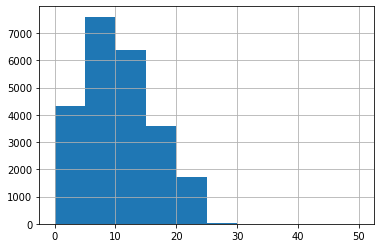

In [41]:
df['total_images'].hist()

In [42]:
df = df.query('total_images > 0')

В столбцах с количеством фотографий значения варьируются от 0 до 50.

Удалили значения, где нет никаких фотографий - такую продажу квартир нет смысла рассматривать


2. Рассмотрим `last_price`

In [43]:
min_max_med(df['last_price'])

minimum 12190
median 4650000.0
maximum 763000000


<AxesSubplot:>

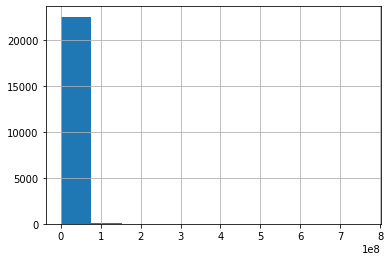

In [44]:
df['last_price'].hist()

<AxesSubplot:>

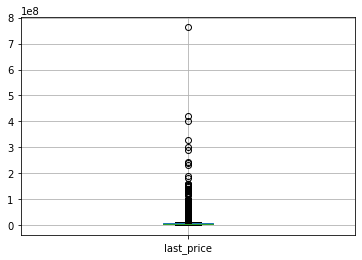

In [45]:
df.loc[:, ['last_price']].boxplot()

Рассмотрим сначала слишком дешевые квартиры

In [46]:
df.query('(last_price < 100000)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,40.5,0,Санкт-Петербург,36421,9176,1,805,0,-1,8.0


In [47]:
df = df.query('last_price > 100000') #удалили квартиру за 12 тысяч

In [48]:
df.query('last_price < 500000').head() # эти квартиры дешевые, но это в деревнях - оставляем

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000,42.0,2017-07-31,2,2.615,1.0,23.0,1,False,...,5.8,0,городской поселок Будогощь,26756,-1,-1,-1,-1,-1,233.0
6859,6,490000,40.0,2017-12-11,1,2.700,5.0,17.6,3,False,...,9.1,0,деревня Старополье,26756,-1,-1,-1,-1,-1,43.0
9581,7,450000,43.4,2018-08-31,2,2.700,5.0,30.3,3,False,...,5.5,0,деревня Старополье,26756,-1,-1,-1,-1,-1,96.0
10782,3,490000,29.1,2016-05-05,1,2.500,5.0,17.0,5,False,...,5.5,0,Сланцы,26756,-1,-1,-1,-1,-1,719.0
14911,5,430000,54.0,2018-06-26,2,2.700,3.0,30.5,3,False,...,9.1,0,поселок станции Свирь,26756,-1,-1,-1,-1,-1,44.0


In [49]:
df = df.query('~(last_price > 410000000)') #удалим квартиры дороже 410млн

<AxesSubplot:>

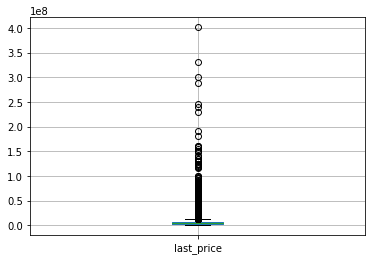

In [50]:
df.loc[:, ['last_price']].boxplot()

Я бы оставила так, но по заданию нужно удалить выбивающиеся значения, поэтому удаляем все, что дороже 175млн

In [51]:
df = df.query('~(last_price > 175000000)')

<AxesSubplot:>

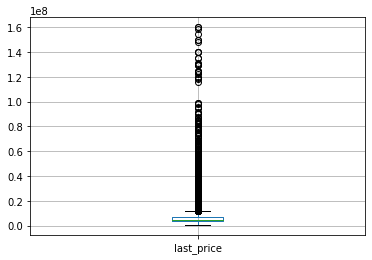

In [52]:
df.loc[:, ['last_price']].boxplot()

In [53]:
min_max_med(df['last_price'])

minimum 430000
median 4650000.0
maximum 160000000


Значения нормальные, оставляем

3. Рассмотрим `total_area`

In [54]:
min_max_med(df['total_area'])

minimum 12.0
median 52.0
maximum 631.2


In [55]:
df.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,95.0
1,7,3350000,40.4,2018-12-04,1,2.63,11.0,18.6,1,False,...,11.0,2,поселок Шушары,12817,18603,0,-1,0,-1,81.0


In [56]:
df[df['living_area'] > df['total_area']].head() #посмотрим где жил площадь больше общей площади, тк это ненормально)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1595,7,3200000,62.4,2019-04-23,4,2.5,5.0,63.8,2,False,...,9.1,1,Кингисепп,26756,-1,-1,-1,-1,-1,95.0
3374,18,3650000,41.5,2018-02-14,3,2.5,5.0,45.0,3,False,...,9.1,0,Санкт-Петербург,12842,11005,0,-1,1,745,24.0
8976,5,4350000,41.2,2017-03-17,3,2.5,5.0,45.0,3,False,...,9.1,0,Санкт-Петербург,14918,9601,0,-1,1,694,560.0
9795,10,4000000,42.0,2017-11-20,3,2.5,5.0,45.0,3,False,...,9.1,0,Санкт-Петербург,11284,12562,1,358,1,117,276.0
9964,5,3500000,49.5,2018-10-02,4,2.7,5.0,63.8,1,False,...,9.1,0,Санкт-Петербург,11609,10539,0,-1,1,96,63.0


Удалим строки, где жилая площадь больше общей площади:

In [57]:
df = df[df['living_area'] <= df['total_area']]

<AxesSubplot:ylabel='Frequency'>

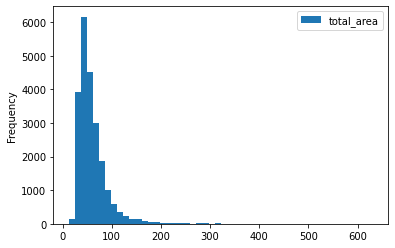

In [58]:
df.plot(kind='hist', y='total_area', bins=50)

<AxesSubplot:>

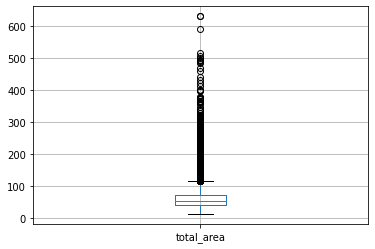

In [59]:
df.loc[:, ['total_area']].boxplot()

Я изучила рынок недвижимости и дальнейшие действия буду совершать на основе анализа "Яндекс недвижимость"

Удалим строки, в которых соотношение площади и цены нереальное. А именно:
- площадь больше 200 кв м, цена меньше 23млн

In [60]:
df.query('(total_area>200) and (last_price < 23000000)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
813,7,16500000,229.00,2016-02-25,8,2.70,6.0,160.000,5,False,...,25.00,0,Санкт-Петербург,23968,4536,1,243,0,-1,806.0
907,2,19500000,211.40,2018-02-22,6,2.70,7.0,140.000,4,False,...,15.20,1,Санкт-Петербург,20581,2279,2,251,3,70,125.0
2003,23,21000000,215.00,2017-11-11,4,2.60,5.0,55.000,2,False,...,17.00,0,Красное Село,24842,28266,1,311,1,1009,14.0
2318,3,17900000,201.90,2018-02-21,6,3.87,6.0,134.800,3,False,...,16.20,0,Санкт-Петербург,23915,3747,0,-1,0,-1,126.0
2462,18,7900000,201.50,2018-08-17,7,2.64,2.0,145.000,2,False,...,9.10,0,поселок Парголово,54990,20665,0,-1,0,-1,35.0
2489,9,12500000,255.00,2017-04-21,3,2.70,2.0,153.900,2,False,...,100.70,0,Санкт-Петербург,29544,6916,0,-1,3,198,102.0
2673,11,16600000,214.00,2017-05-11,7,3.20,5.0,131.000,4,False,...,14.40,0,Санкт-Петербург,24542,4761,2,669,0,-1,173.0
3303,20,15750000,214.00,2018-06-15,4,2.70,17.0,159.200,17,False,...,40.00,0,Сестрорецк,56588,33517,0,-1,1,703,264.0
3315,6,16250000,210.40,2019-04-08,7,2.57,16.0,159.200,15,False,...,15.40,0,Санкт-Петербург,21137,22849,0,-1,2,348,95.0
5451,5,16800000,202.00,2017-11-02,7,3.70,5.0,145.000,4,False,...,20.00,1,Санкт-Петербург,27035,5738,2,467,2,429,268.0


In [61]:
df = df.query('~((total_area>200) and (last_price < 23000000))') #удалим строки, в которых площадь больше 200 кв м, а цена меньше 23 млн.

- площадь больше 400 кв м, цена меньше 95 млн:


In [62]:
df.query('(total_area>400) and (last_price < 95000000)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
660,3,49950000,483.90,2017-10-04,7,3.20,6.0,312.500,4,False,...,26.40,0,Санкт-Петербург,23079,945,3,461,3,22,391.0
3676,12,28789000,441.98,2019-01-23,4,2.70,6.0,63.800,6,False,...,35.05,0,Санкт-Петербург,20552,5181,0,-1,0,-1,95.0
4237,1,50000000,517.00,2017-10-14,7,2.70,4.0,332.000,3,False,...,22.00,0,Санкт-Петербург,22835,1847,2,477,2,540,95.0
5358,20,65000000,590.00,2019-02-14,15,3.50,6.0,409.000,3,False,...,100.00,0,Санкт-Петербург,24447,4666,1,767,0,-1,14.0
6221,8,34000000,470.30,2018-01-14,4,2.70,3.0,248.700,3,False,...,40.00,0,Санкт-Петербург,43756,15459,1,852,3,122,179.0
8018,20,84000000,507.00,2015-12-17,5,4.45,7.0,301.500,7,True,...,45.50,1,Санкт-Петербург,26756,5735,2,110,0,-1,1078.0
9826,1,43185328,494.10,2017-05-12,1,2.85,12.0,17.600,3,False,...,9.10,0,Санкт-Петербург,28529,6832,1,592,0,-1,5.0
12401,20,91500000,495.00,2017-06-19,7,4.65,7.0,347.500,7,False,...,25.00,0,Санкт-Петербург,26756,5735,2,110,0,-1,14.0
14088,8,51000000,402.00,2017-02-07,6,3.15,8.0,300.000,6,False,...,56.00,2,Санкт-Петербург,24484,5052,1,253,0,-1,32.0
14991,19,45000000,413.50,2018-09-20,7,2.70,20.0,74.200,18,False,...,13.90,0,Санкт-Петербург,18748,4341,0,-1,0,-1,182.0


In [63]:
df = df.query('~((total_area>400) and (last_price < 95000000))') #удалим строки, в которых площадь больше 400 кв м, а цена меньше 95 млн.


- площади больше 100 кв м, цена меньше 200млн в г.Санкт-Петербурге:

In [64]:
df.query('(total_area>100) and (last_price < 2000000)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4659,1,1650000,115.0,2019-02-28,5,2.50,5.0,71.0,1,False,...,11.0,0,Сланцы,26756,-1,-1,-1,-1,-1,95.0
17753,12,1800000,117.3,2016-02-18,5,2.70,4.0,23.6,2,False,...,12.9,0,Санкт-Петербург,24670,5238,0,-1,0,-1,139.0
23477,3,1450000,138.0,2018-07-06,3,2.55,2.0,58.0,2,False,...,12.0,0,Гатчина,26756,-1,-1,-1,-1,-1,52.0


In [65]:
df = df.query('~((total_area>100) and (last_price < 2000000) and (locality_name == "Санкт-Петербург"))') #1.8 млн за 100 кв м  комнат в Питере - вброс.В Гатчине и Сланцах мб.

In [66]:
df.query('(total_area>600)') #посмотрим квартиры с большой площадью

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3117,19,140000000,631.0,2019-03-30,7,2.7,5.0,145.0,5,False,...,60.0,0,Санкт-Петербург,25707,4972,0,-1,2,210,95.0
12859,20,140000000,631.2,2019-04-09,7,3.9,4.0,322.3,4,False,...,19.5,1,Санкт-Петербург,25707,4972,0,-1,2,210,95.0


In [67]:
df = df.query('~(total_area>600)') #слишком дешево за 600кв м такие цены

Удалили все строки, где площадь более 600кв м

<AxesSubplot:ylabel='Frequency'>

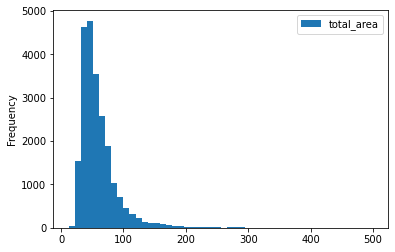

In [68]:
df.plot(kind='hist', y='total_area', bins=50)

<AxesSubplot:>

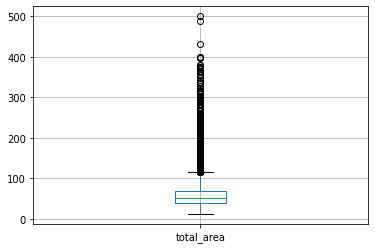

In [69]:
df.loc[:, ['total_area']].boxplot()

Cудя по графику plot еще следует удалить квартиры, больше 250 кв м

In [70]:
df = df.query('total_area < 250')

<AxesSubplot:ylabel='Frequency'>

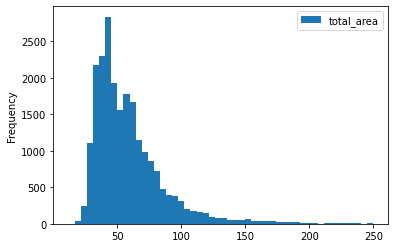

In [71]:
df.plot(kind='hist', y='total_area', bins=50)

<AxesSubplot:>

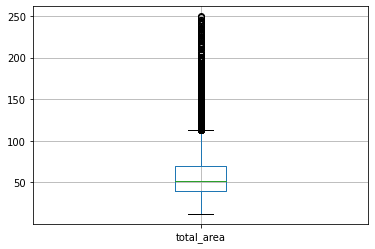

In [72]:
df.loc[:, ['total_area']].boxplot()

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

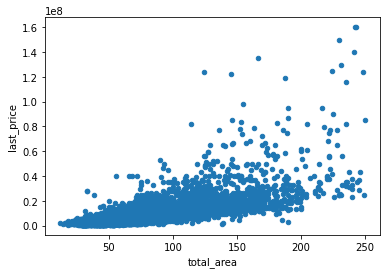

In [73]:
df.plot(kind='scatter', x = 'total_area', y = 'last_price')

In [74]:
min_max_med(df['total_area'])

minimum 12.0
median 52.0
maximum 249.7


Графики нормальные, оставляем данные так

4. Рассмотрим `rooms`

In [75]:
min_max_med(df['rooms'])

minimum 0
median 2.0
maximum 14


<AxesSubplot:ylabel='Frequency'>

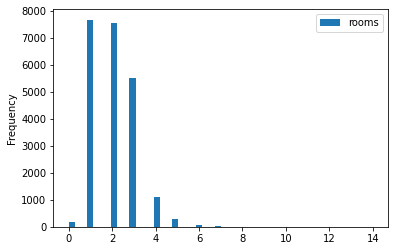

In [76]:
df.plot(kind='hist',y='rooms', bins = 50)

<AxesSubplot:>

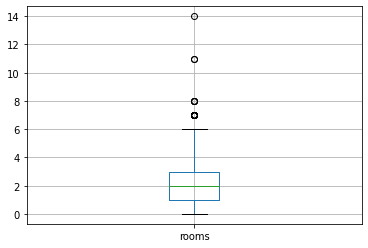

In [77]:
df.loc[:, ['rooms']].boxplot()


<AxesSubplot:xlabel='rooms', ylabel='last_price'>

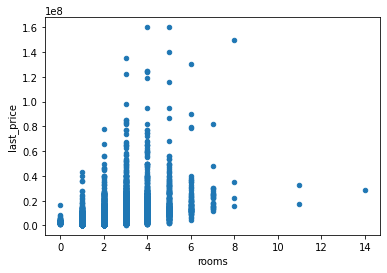

In [78]:
df.plot(x='rooms', y='last_price', kind='scatter')

Квартиры, в которых больше 6 комнат действительно есть на рынке, но у них должна быть соответсвующая цена. Удалим квартиры, у которых соотношение кол-ва комнат и цены нереальное

In [79]:
df = df.query('~((rooms > 10) and (last_price < 400000000))') #не может быть большше 10 комнат и дешевле 400млн

In [80]:
df = df.query('~((rooms>6) and (last_price < 30000000))') #не может быть большше 6 комнат и дешевле 30млн

In [81]:
df = df.query('~((rooms>7) and (last_price < 60000000))')  #не может быть большше 7 комнат и дешевле млн

5. Рассмотрим `ceiling_height`

In [82]:
min_max_med(df['ceiling_height'])

minimum 1.0
median 2.7
maximum 32.0


array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

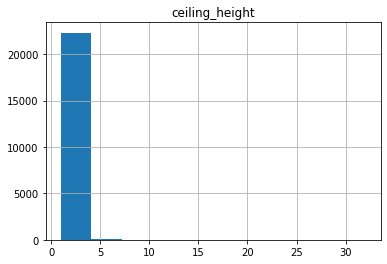

In [83]:
df.loc[:,['ceiling_height']].hist()

<AxesSubplot:>

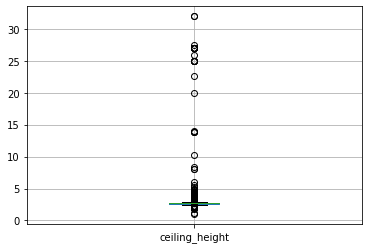

In [84]:
df.loc[:,['ceiling_height']].boxplot()

In [85]:
df = df.query('(ceiling_height != 100) and (ceiling_height > 2)') #уберем значение потолка, который равен 100м и которые меньше 2м

In [86]:
min_max_med(df['ceiling_height'])

minimum 2.2
median 2.7
maximum 32.0


<AxesSubplot:>

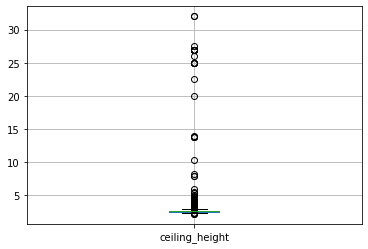

In [87]:
df.loc[:,['ceiling_height']].boxplot()

Остались значения потолка выше 20м. Скорее всего это опечатка и это не 20м,а 2м

Будем считать (исходя из boxplot), что допустимая высота потолка - 5м

In [88]:
df.loc[df['ceiling_height'] > 5]['ceiling_height'] = df.loc[df['ceiling_height'] > 5]['ceiling_height'] / 10
#значения, которые больше 5м поделим на 10

/tmp/ipykernel_48/4284391438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['ceiling_height'] > 5]['ceiling_height'] = df.loc[df['ceiling_height'] > 5]['ceiling_height'] / 10


In [89]:
#df['ceiling_height'] =  df['ceiling_height'].where( df['ceiling_height'] < 5, df['ceiling_height'] / 10)

In [90]:
df = df.query('2 < ceiling_height < 5') #оставим только потолки с высотой от 2 до 5м

<AxesSubplot:>

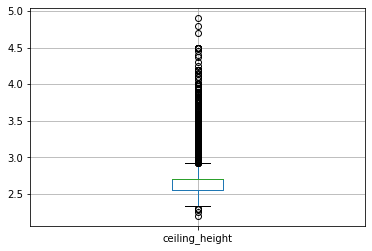

In [91]:
df.loc[:,['ceiling_height']].boxplot()

In [92]:
min_max_med(df['ceiling_height'])

minimum 2.2
median 2.7
maximum 4.9


Теперь данные про высоту потолков в норме

6. Рассмотрим `floors_total` и `floors`

<AxesSubplot:>

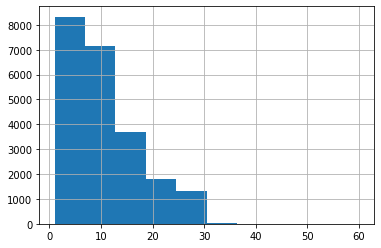

In [93]:
df['floors_total'].hist()

<AxesSubplot:>

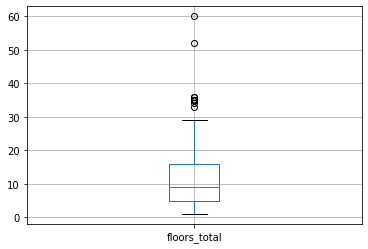

In [94]:
df.loc[:,['floors_total']].boxplot()

In [95]:
df = df.query('floors_total<30') #в СПБ есть только одно здание выше 30 этажей. Но вряд ли все эти квартиры из этого дома

In [96]:
df = df[df['floor'] <= df['floors_total']] #удалим значения, в которых номер этажа выше общего кол-ва этажей

<AxesSubplot:>

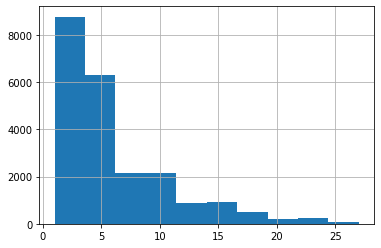

In [97]:
df['floor'].hist()

<AxesSubplot:>

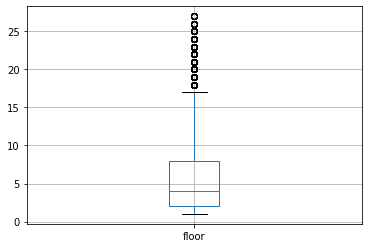

In [98]:
df.loc[:,['floor']].boxplot()

Данные все в порядке. Есть высокоэтажные здания и квартиры на высоких этажах. Их довольно мало, что объясняется особенностями Спб (Пишу из Питера с 16 этажа и не вижу ни одного здания больше 10 этажей)

7. Рассмотрим `living_area`

In [99]:
min_max_med(df['living_area'])

minimum 2.0
median 30.165
maximum 220.0


Жилая площадь в 2 кв м - издевательство над людьми. Должно быть минимум 7.

In [100]:
df.query('living_area  < 7') #таких всего лишь 7

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000,41.0,2017-07-02,1,2.7,17.0,3.0,17,False,...,11.0,0,Санкт-Петербург,19272,13073,0,-1,0,-1,216.0
13915,20,6350000,52.0,2018-02-06,2,3.0,6.0,2.0,2,False,...,9.0,0,Санкт-Петербург,32453,6521,0,-1,1,1012,91.0
16431,13,3799000,31.0,2018-04-12,1,2.6,5.0,6.0,1,False,...,17.0,0,Санкт-Петербург,32177,4826,1,430,0,-1,168.0
17582,11,2680000,22.0,2018-08-11,0,2.7,25.0,5.0,8,False,...,9.1,2,Санкт-Петербург,22735,11618,1,835,1,652,70.0
19251,19,4050000,33.0,2018-10-15,1,2.5,22.0,6.5,21,False,...,18.0,0,Санкт-Петербург,9258,10592,1,458,0,-1,44.0
21943,15,6100000,77.6,2019-02-28,4,2.5,9.0,5.4,1,False,...,9.8,0,Санкт-Петербург,29338,11270,1,584,0,-1,33.0
23574,14,64990000,139.0,2015-11-24,3,3.0,8.0,3.0,8,False,...,16.0,1,Санкт-Петербург,33255,5975,1,630,3,100,280.0


In [101]:
df = df.query('living_area > 7') #cмело удаляем квартиры, в которых жил площадь меньше 7

<AxesSubplot:>

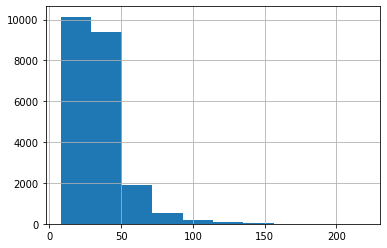

In [102]:
df['living_area'].hist()

<AxesSubplot:>

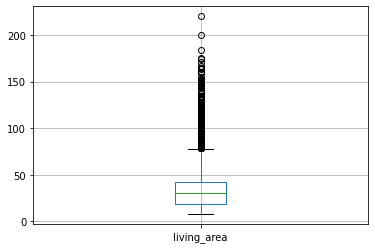

In [103]:
df.loc[:,['living_area']].boxplot()

<AxesSubplot:xlabel='living_area', ylabel='rooms'>

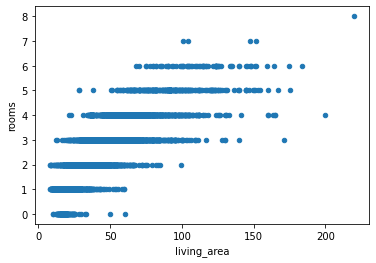

In [104]:
df.plot(kind='scatter', x = 'living_area', y = 'rooms')

По scatter мы видим выбивающиеся значения, уберем их:

In [105]:
df = df.query('~((living_area > 48) and (rooms==0))') #жил плоащдь больше 48, но комнат 0

In [106]:
df = df.query('~((living_area > 99) and (rooms==2))')#жил плоащдь больше 99, но комнат 2

In [107]:
df = df.query('~((living_area > 120) and (rooms==3))')#жил плоащдь больше 120, но комнат 3

In [108]:
df = df.query('~(((living_area > 140) or (living_area < 25)) and (rooms==4))') #жил плоащдь больше 140 или меньше 25, но комнат 4

In [109]:
df = df.query('~(((living_area > 200) or (living_area < 40)) and (rooms==5))')#жил плоащдь больше 200 или меньше 40, но комнат 5

In [110]:
df = df.query('living_area < 170') #удалим квартиры с площадью более 170кв м

<AxesSubplot:xlabel='living_area', ylabel='rooms'>

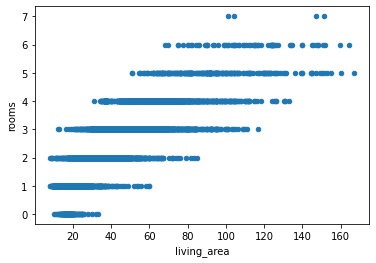

In [111]:
df.plot(kind='scatter', x = 'living_area', y = 'rooms')

In [112]:
min_max_med(df['living_area'])

minimum 8.0
median 30.1
maximum 167.0


График стал более красивым, оставляем

8. Pассмотрим `is_apartment`, `studio`, `open_plan`

In [113]:
df['is_apartment'].value_counts() #данные в норме, оставляем (апартаментов должно быть мало)

False    22202
True        43
Name: is_apartment, dtype: int64

In [114]:
df['studio'].value_counts() #данные в норме

False    22109
True       136
Name: studio, dtype: int64

In [115]:
df['open_plan'].value_counts() #норм)

False    22190
True        55
Name: open_plan, dtype: int64

9. Рассмотрим `kitchen_area`

In [116]:
min_max_med(df['kitchen_area'])

minimum 1.3
median 9.1
maximum 107.0


Кухни меньше 6 кв м - кошмар! Посмотрим сколько их

In [117]:
df.query('kitchen_area < 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13,20,3550000,42.8,2017-07-01,2,2.56,5.0,27.0,5,False,...,5.2,1,Петергоф,37868,33058,1,294,3,298,366.0
18,8,3250000,31.0,2017-01-27,1,2.50,5.0,19.4,2,False,...,5.6,1,Санкт-Петербург,44060,10842,1,759,0,-1,168.0
21,13,3200000,31.6,2018-03-14,1,2.70,5.0,16.9,2,False,...,5.7,1,Санкт-Петербург,36064,9722,1,248,0,-1,310.0
47,17,3600000,56.1,2018-10-18,3,2.55,4.0,42.5,3,False,...,5.7,1,Гатчина,26756,-1,-1,-1,-1,-1,179.0
64,13,3100000,44.3,2017-11-07,2,2.50,5.0,29.0,5,False,...,5.3,0,Гатчина,26756,-1,-1,-1,-1,-1,143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23660,1,2950000,53.6,2018-02-01,2,2.75,3.0,32.0,3,False,...,5.8,1,Красное Село,38293,41718,0,-1,0,-1,35.0
23673,9,3100000,23.0,2018-03-19,1,2.80,9.0,12.6,1,False,...,5.0,2,Санкт-Петербург,11813,11881,1,262,1,442,41.0
23678,10,3500000,43.0,2016-05-19,2,2.50,3.0,26.1,2,False,...,4.9,1,Пушкин,15823,27977,0,-1,1,1134,252.0
23683,16,2100000,62.8,2018-09-18,4,2.50,5.0,45.5,3,False,...,5.5,0,поселок Дзержинского,26756,-1,-1,-1,-1,-1,95.0


Их очень много, убавим до 5(такие бывают?)

In [118]:
df.query('kitchen_area < 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
76,12,2800000,55.1,2016-05-14,3,2.60,5.0,38.4,1,False,...,4.9,0,Кировск,26756,-1,-1,-1,-1,-1,606.0
298,9,2650000,42.8,2017-04-25,2,2.55,5.0,30.0,3,False,...,4.5,0,Гатчина,26756,-1,-1,-1,-1,-1,49.0
422,8,1700000,55.2,2018-03-24,3,2.50,5.0,38.5,5,False,...,4.5,0,Кириши,26756,-1,-1,-1,-1,-1,95.0
906,15,2600000,27.0,2017-07-10,1,2.75,23.0,18.0,18,False,...,2.0,0,Санкт-Петербург,22131,17459,0,-1,1,411,10.0
1327,6,2650000,46.2,2016-12-01,2,2.50,5.0,29.2,5,False,...,4.9,0,Гатчина,26756,-1,-1,-1,-1,-1,704.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22839,14,3350000,27.0,2018-11-03,1,2.70,16.0,17.6,6,False,...,4.0,2,Санкт-Петербург,41935,9551,0,-1,0,-1,35.0
22849,6,2380000,25.0,2016-03-22,1,2.63,25.0,19.0,15,False,...,4.0,1,поселок Шушары,13461,19247,0,-1,1,351,140.0
23110,1,2900000,34.0,2018-02-01,2,2.90,2.0,20.0,1,False,...,4.0,0,поселок Стрельна,27006,23832,0,-1,2,872,196.0
23498,7,1600000,54.0,2016-12-26,2,2.30,1.0,33.0,1,False,...,3.5,0,Высоцк,26756,-1,-1,-1,-1,-1,281.0


In [119]:
df = df.query('kitchen_area > 5') #Удалим кухни меньше 5 кв м

<AxesSubplot:>

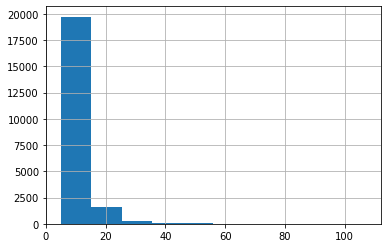

In [120]:
df['kitchen_area'].hist()

<AxesSubplot:>

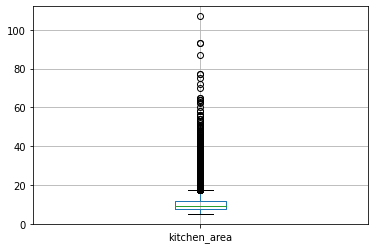

In [121]:
df.loc[:,['kitchen_area']].boxplot()

In [122]:
df = df.query('kitchen_area < 70') #удалим сильно выбивающиеся значения

<AxesSubplot:>

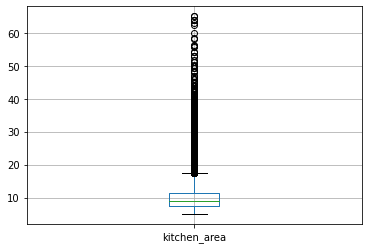

In [123]:
df.loc[:,['kitchen_area']].boxplot()

In [124]:
min_max_med(df['kitchen_area'])

minimum 5.04
median 9.1
maximum 65.0


10. Рассмотрим `balcony`

In [125]:
min_max_med(df['balcony'])

minimum 0
median 0.0
maximum 5


<AxesSubplot:>

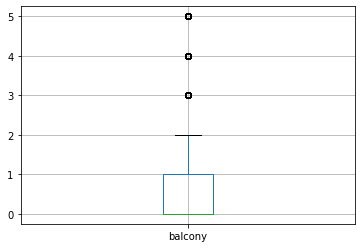

In [126]:
df.loc[:,['balcony']].boxplot()

In [127]:
df = df.query('balcony < 3') #оставим квартиры с 0-2 балконами

<AxesSubplot:>

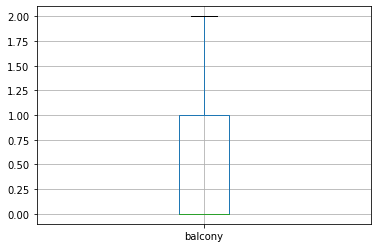

In [128]:
df.loc[:,['balcony']].boxplot()

11. Рассмотрим `airports_nearest`

In [129]:
min_max_med(df['airports_nearest'])

minimum 6450
median 26756.0
maximum 84869


<AxesSubplot:>

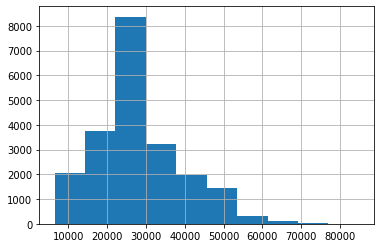

In [130]:
df['airports_nearest'].hist()

<AxesSubplot:>

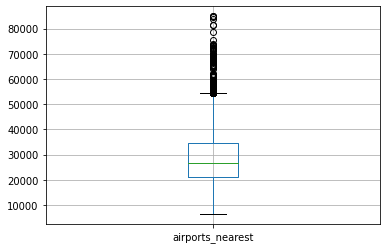

In [131]:
df.loc[:,['airports_nearest']].boxplot()

15. Рассмотрим `days_exposition`

In [132]:
min_max_med(df['days_exposition'])

minimum 1.0
median 95.0
maximum 1572.0


<AxesSubplot:>

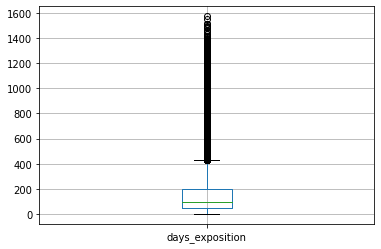

In [133]:
df.loc[:,['days_exposition']].boxplot()

<AxesSubplot:>

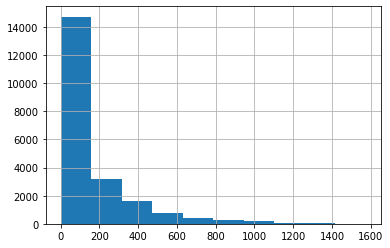

In [134]:
df['days_exposition'].hist()

Аномальных значений нет, разве что уберем квартиры, которые висели больше 1400 дней (это почти 4 года)

In [135]:
df = df.query('days_exposition < 1400')

Все значения адекватные, явных вбросов нет

12. Рассмотрим `cityCenters_nearest`

In [136]:
min_max_med(df['cityCenters_nearest'])

minimum -1
median 11273.0
maximum 65968


<AxesSubplot:>

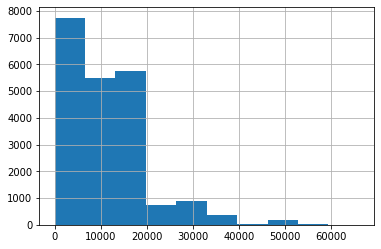

In [137]:
df['cityCenters_nearest'].hist()

<AxesSubplot:>

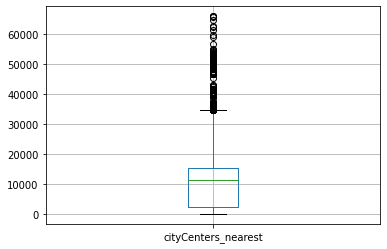

In [138]:
df.loc[:,['cityCenters_nearest']].boxplot()

13. Рассмотрим `parks_around3000` и `ponds_around3000`

In [139]:
min_max_med(df['parks_around3000'])

minimum -1
median 0.0
maximum 3


In [140]:
min_max_med(df['ponds_around3000'])

minimum -1
median 0.0
maximum 3


<AxesSubplot:>

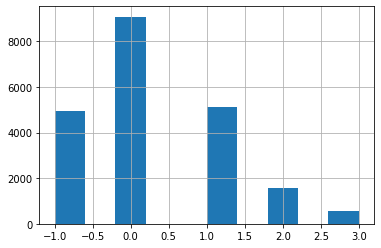

In [141]:
df['parks_around3000'].hist()

<AxesSubplot:>

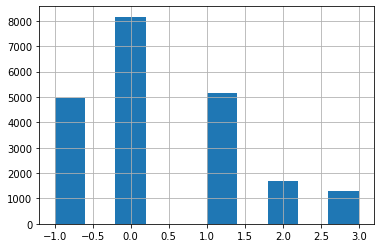

In [142]:
df['ponds_around3000'].hist()

Аномальных значений нет

14. Рассмотрим `parks_nearest` и `ponds_nearest`

In [143]:
min_max_med(df['parks_nearest']) 

minimum -1
median -1.0
maximum 3190


In [144]:
min_max_med(df['ponds_nearest'])

minimum -1
median -1.0
maximum 1344


<AxesSubplot:>

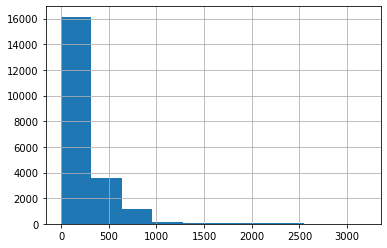

In [145]:
df['parks_nearest'].hist()

<AxesSubplot:>

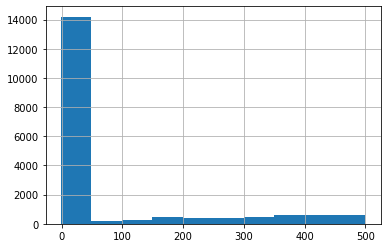

In [146]:
df['parks_nearest'].hist(range = (-1, 500)) #посмотрим поближе

<AxesSubplot:>

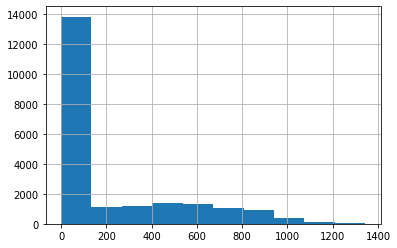

In [147]:
df['ponds_nearest'].hist()

<AxesSubplot:>

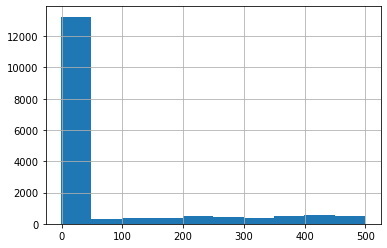

In [148]:
df['ponds_nearest'].hist(range = (-1, 500)) #посмотрим поближе

<AxesSubplot:>

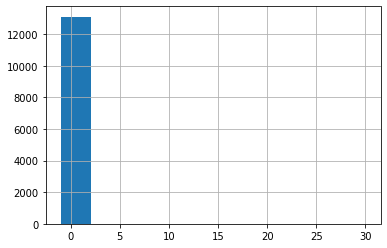

In [149]:
df['ponds_nearest'].hist(range = (-1, 30)) #посмотрим еще ближе

<div class="alert alert-info">

График тут лучше отображает наличие аномалий. Мы увидели, что большой пик принадлежт заглушкам (-1)

Но аномальных значений не нашли
    
Конец анализа).

Поиск аномальных значений закончили. Их было не очень много. Осталось сбросить индексы

In [150]:
df = df.reset_index()

In [151]:
df.head(3)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,95.0
1,1,7,3350000,40.4,2018-12-04,1,2.63,11.0,18.6,1,...,11.0,2,поселок Шушары,12817,18603,0,-1,0,-1,81.0
2,2,10,5196000,56.0,2015-08-20,2,2.70,5.0,34.3,4,...,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0


Мы проделали большую работу по очищению данных.
- `total_images` убрали значения, где нет фотографий
- `last_price` для лучшего анализа убрали выбивающиеся слишком дешевые и слишком дорогие квартиры
- `total_area` удалили значения, которые не соответствуют по цене и общей площади (площадь больше 200 кв м, цена меньше 23млн, площадь больше 400 кв м, цена меньше 95 млн, площади больше 100 кв м, цена меньше 200млн в г.Санкт-Петербурге). Удалили все строки, площадь которых более 250 кв м.
- `rooms` убрали неподходящие значения по цене и количеству комнат
- `ceiling_height` потолки высотой больше 20 поделили на 10, так как это скорее всего опечатка. Оставили значения высоты потолка от 2 до 5 метров
- `floors_total` и `floors` аномальных значений не найдено
- `living_area` Убрали жил площадь меньше 7 квадратных метров и квартиры, которые не соответствуют по жилой площади и количеству комнат 
- `kitchen_area` удалили кухни, которые меньше 5 кв м и больше 70 кв м
- `balcony` оставили только квартиры с 2 балконами
- `airports_nearest` ,  `cityCenters_nearest`, `parks_around3000` ,  `ponds_around3000`, `parks_nearest` и `ponds_nearest` оставили как было
- `days_exposition` убрали квартиры, которые висели больше 1400 дней


## Добавление новых столбцов

In [152]:
df['price_of_one_square_m'] = df['last_price'] / df['total_area'] # добавили цену кв метра

In [153]:
df['weekday'] = df['first_day_exposition'].dt.weekday # день недели добавили

In [154]:
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month #добавила месяц

In [155]:
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

In [156]:
def kind_floor(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    return 'другой'
df['kind_floor'] = df.apply(kind_floor, axis=1)
#добавили тип этажа

In [157]:
df['cityCenters_km'] = df['cityCenters_nearest'].transform(lambda x: x // 1000)

In [158]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_one_square_m,weekday,month,year,kind_floor,cityCenters_km
0,0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,...,482,2,755,95.0,120370.370370,3,3,2019,другой,16
1,1,7,3350000,40.4,2018-12-04,1,2.63,11.0,18.6,1,...,-1,0,-1,81.0,82920.792079,1,12,2018,первый,18
2,2,10,5196000,56.0,2015-08-20,2,2.70,5.0,34.3,4,...,90,2,574,558.0,92785.714286,3,8,2015,другой,13
3,4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,...,112,1,48,121.0,100000.000000,1,6,2018,другой,8
4,5,10,2890000,30.4,2018-09-10,1,2.60,12.0,14.4,5,...,-1,-1,-1,55.0,95065.789474,0,9,2018,другой,-1


Все столбцы корректно добавились

In [159]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21251 entries, 0 to 21250
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  21251 non-null  int64         
 1   total_images           21251 non-null  int32         
 2   last_price             21251 non-null  int64         
 3   total_area             21251 non-null  float64       
 4   first_day_exposition   21251 non-null  datetime64[ns]
 5   rooms                  21251 non-null  int64         
 6   ceiling_height         21251 non-null  float64       
 7   floors_total           21251 non-null  float64       
 8   living_area            21251 non-null  float64       
 9   floor                  21251 non-null  int64         
 10  is_apartment           21251 non-null  bool          
 11  studio                 21251 non-null  bool          
 12  open_plan              21251 non-null  bool          
 13  k

## Исследовательский анализ данных

### Изучим параметры данных

Стоит сразу заметить, что уже многие аномальные значения убраны 

1. `total_area`

<AxesSubplot:title={'center':'Общая площадь'}, ylabel='Frequency'>

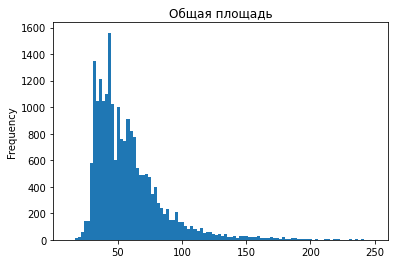

In [160]:
df['total_area'].plot(kind='hist', title ='Общая площадь', bins=100)

Площадь квартир варьируется от 20 до 250кв м

Больше всего квартир площадью около 45 кв м

В среднем квартиры имеют площадь от 30 до 70 кв м

Можно заметить, что квартир площадью 50кв м почти в три раза меньше, чем квартир с площадью 45км.м Это довольно странно, но может объясняться существующими гостами о площади квартир

2. `living_area`

<AxesSubplot:title={'center':'Жилая площадь'}, ylabel='Frequency'>

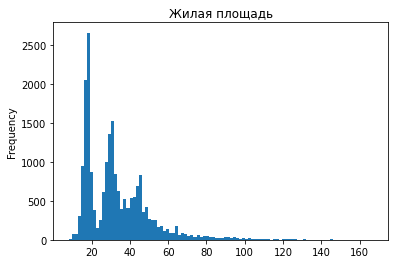

In [161]:
df['living_area'].plot(kind='hist', title ='Жилая площадь', bins=100)

В среднем жилая площадь составляет 15кв.м

На графике виден странный спад между двумя пиками. Речь о квартирах с жил площадью около 25кв. Это очень странно, учитывая, что медиана равна 30

In [162]:
df['living_area'].median()

30.0

Есть теория, что этот спад как-то вызыван количеством комнат, хочется построить еще один график и сравнить


<AxesSubplot:xlabel='living_area', ylabel='rooms'>

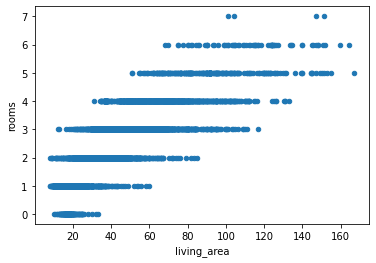

In [163]:
df.plot(kind='scatter', x = 'living_area', y = 'rooms')

In [164]:
df.groupby('rooms')['living_area'].mean()

rooms
0     18.359425
1     17.866507
2     31.669520
3     47.122138
4     65.319376
5     92.143173
6    111.932571
7    125.925000
Name: living_area, dtype: float64

Действительно, квартиры с жилой площадью в 22 метра не подходят ни под однокомнатные, ни под двухкмонатные квартиры


3. `kitchen_area`

<AxesSubplot:title={'center':'Площадь кухни'}, ylabel='Frequency'>

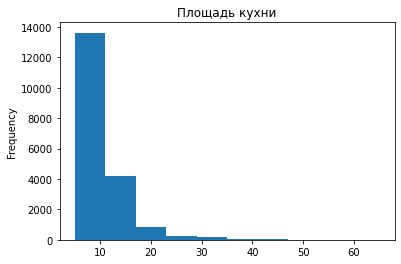

In [165]:
df[df['kitchen_area'] != df['kitchen_area'].median()]['kitchen_area'].plot(kind='hist', title ='Площадь кухни')

<AxesSubplot:title={'center':'Площадь кухни'}, ylabel='Frequency'>

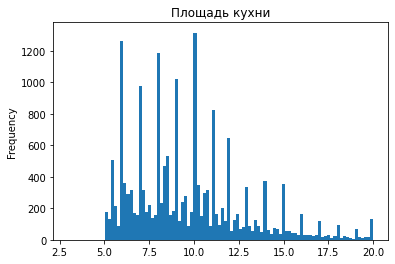

In [166]:
df[df['kitchen_area'] != df['kitchen_area'].median()]['kitchen_area'].plot(kind='hist', title ='Площадь кухни', bins=100, range=(3,20))

Есть определенный гост и стандарты с какой площадью делать кухню. Это значение варьируется. В основном это 6,8,10 кв метров


<AxesSubplot:xlabel='kitchen_area', ylabel='total_area'>

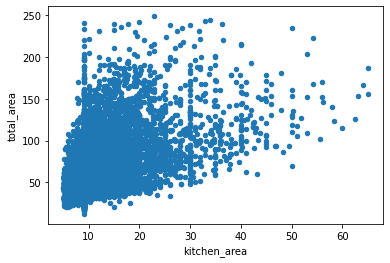

In [167]:
df.plot(kind='scatter', x = 'kitchen_area', y = 'total_area')

График сильно варьируется, есть много спадов и пиков. По моему мнению это потому что есть перечень, мол кухня стандартно либо 6, либо 8, либо 10. А вообще эти 2кв м роли не играют 

По графику видно, что есть некая зависмость площади кухни от общей площади

4. `last_price`

<AxesSubplot:title={'center':'Цена объекта'}, ylabel='Frequency'>

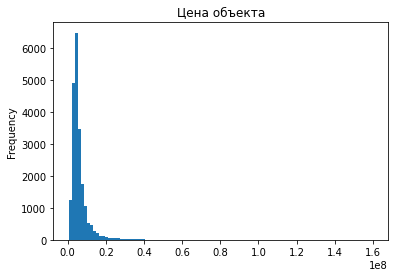

In [168]:
df['last_price'].plot(kind='hist', title ='Цена объекта', bins=100)

Цена очень сильно варьируется от 500 тысяч до 160 млн рублей

Квартиры, стоимостью более 20млн рублей встречаются редко, что вполне объяснимо

<AxesSubplot:title={'center':'Цена объекта'}, ylabel='Frequency'>

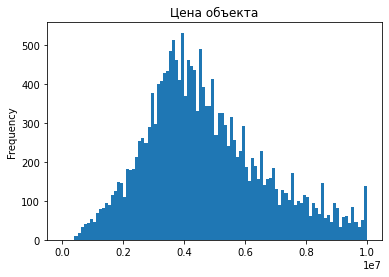

In [169]:
df['last_price'].plot(kind='hist', title ='Цена объекта', bins=100, range=(0,10000000))

При уменьшении графика можно заметить, что квартиры в среднем стоят от 3 до 6 млн рублей

Квартиры от 500к до 2 млн скорее всего продаются в Лен.области

5. `rooms`

<AxesSubplot:title={'center':'Количество комнат'}, ylabel='Frequency'>

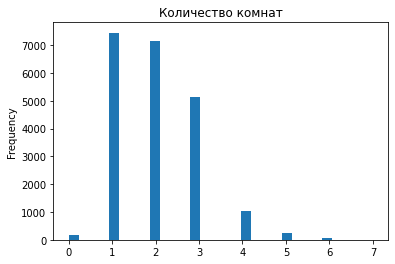

In [170]:
df['rooms'].plot(kind='hist', title ='Количество комнат', bins=30)

Простой и понятный график). 

Чаще всего продают 1-х или 2-х комнатные квартиры. 

Студий довольно мало, что довольно странно.

4,5 и 6-комнатные квартиры продаются реже, так как таких квартир просто мало.

6. `ceiling_height`

<AxesSubplot:title={'center':'Высота потолков'}, ylabel='Frequency'>

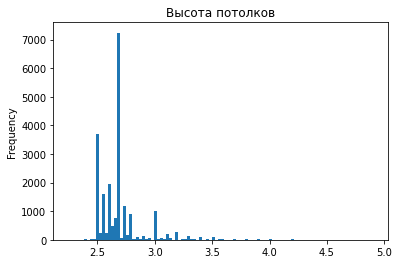

In [171]:
df['ceiling_height'].plot(kind='hist', title ='Высота потолков', bins = 100)

<AxesSubplot:title={'center':'Высота потолков'}, ylabel='Frequency'>

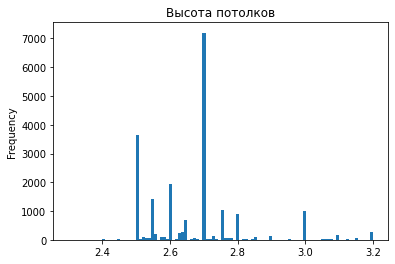

In [172]:
df['ceiling_height'].plot(kind='hist', title ='Высота потолков', bins = 100, range=(2.3, 3.2))

Есть определенные стандарты, какие должны быть потолки. Судя по графику - обычно строятся здания с потолками в 2,7 м.

Допускается также 2,5 или 3м (зависит скорее от эпохи, когда строили здание)

7. `floor`

<AxesSubplot:title={'center':'Этаж квартиры'}, ylabel='Frequency'>

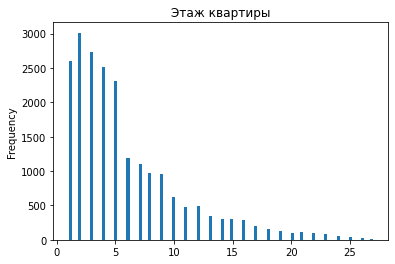

In [173]:
df['floor'].plot(kind='hist', title ='Этаж квартиры', bins = 100)

Обычно продают квартиры с 1 по 5 этаж. Это можно объянсить тем, что здания в Спб довольно низкие. 

Удостовериться в этой теории можно будет дальше, когда изучим гистограму `floors_total`

8. `kind_floor`

<AxesSubplot:>

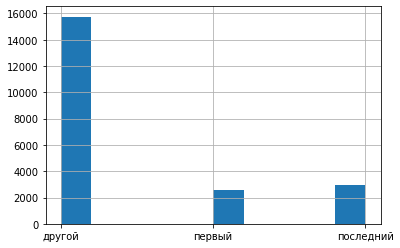

In [174]:
df['kind_floor'].hist()
#plot(kind='hist', title ='Общее количество этажей', bins = 100)

In [175]:
df['kind_floor'].value_counts()

другой       15749
последний     2924
первый        2578
Name: kind_floor, dtype: int64

Квартиры на последних этажах продают чуть больше, чем на первых. Но все-таки большую часть составляют квартиры, которые не находятся на крайних этажах

9. `floors_total`

<AxesSubplot:title={'center':'Общее количество этажей'}, ylabel='Frequency'>

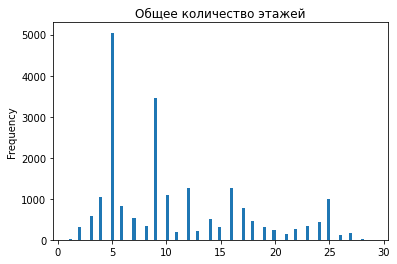

In [176]:
df['floors_total'].plot(kind='hist', title ='Общее количество этажей', bins = 100)

Тут тоже все понятно - обычно дома строят 5,9,16 или 25-этажные.

Много пятиэтажных домов из-за особенностей Питера


10. `cityCenters_nearest`

<AxesSubplot:title={'center':'Расстояние до центра города'}, ylabel='Frequency'>

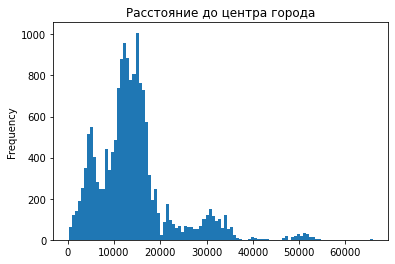

In [177]:
df[df['cityCenters_nearest'] != -1]['cityCenters_nearest'].plot(kind='hist', title ='Расстояние до центра города', bins = 100)

Для города среднее растояние до центра - 10-20 километров. 

<AxesSubplot:title={'center':'Расстояние до центра города'}, ylabel='Frequency'>

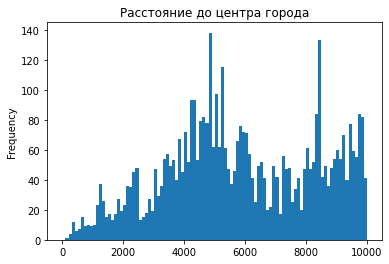

In [178]:
df['cityCenters_nearest'].plot(kind='hist', title ='Расстояние до центра города', bins = 100, range=(0,10000))

Мои вставленные значения все испортили). Но правда, если мы говорим о  деревнях и селах, то примерно такая цифра в 2 км до центра будет.

Проверю на практике - посмотрю сколько всего разных локаций в датасете кроме СПБ

In [179]:
df['locality_name'].str.contains('Санкт-Петербург').value_counts()

True     14221
False     7030
Name: locality_name, dtype: int64

В датасете 14к квартир из Питера, 7к квартир из Лен области.


11. `airports_nearest`

<AxesSubplot:title={'center':'Расстояние до аэропорта'}, ylabel='Frequency'>

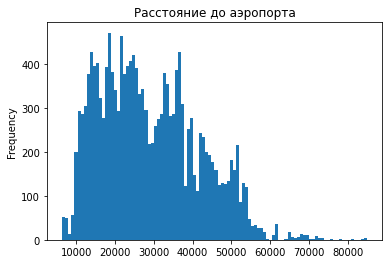

In [180]:
df[df['airports_nearest'] != df['airports_nearest'].median()]['airports_nearest'].plot(kind='hist', title ='Расстояние до аэропорта', bins = 100)

Данные сильно варьируются. Среднее расстояние до аэропорта оставляет от 10 до 40 километров в среднем


12. `parks_nearest`

<AxesSubplot:title={'center':'Расстояние до ближайшего парка'}, ylabel='Frequency'>

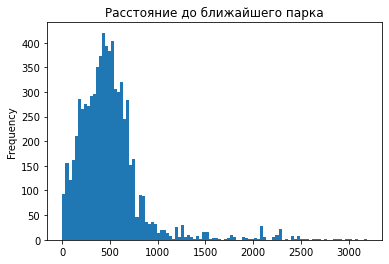

In [181]:
df[df['parks_nearest'] != -1]['parks_nearest'].plot(kind='hist', title ='Расстояние до ближайшего парка', bins = 100)

<AxesSubplot:title={'center':'Расстояние до ближайшего парка'}, ylabel='Frequency'>

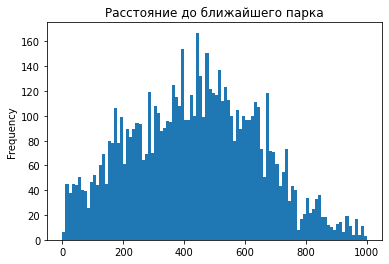

In [182]:
df[df['parks_nearest'] != -1]['parks_nearest'].plot(kind='hist', title ='Расстояние до ближайшего парка', bins = 100, range=(0, 1000))

До ближайшего парка в среднем 200-600 метров

12. `weekday` и `month`

Я не особо понимаю как их анализировать вместе, поэтому пройдусь по отдельности.

<AxesSubplot:title={'center':'День публикации объявления'}, ylabel='Frequency'>

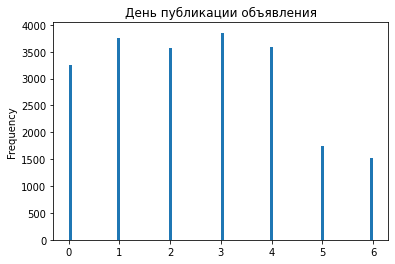

In [183]:
df['weekday'].plot(kind='hist', title ='День публикации объявления', bins = 100)

Продавцы редко выставляют квартиры в выходные дни.

В будние дни объявления на продажу выставляются с почти одинаковой частотой. Но чаще всего во вторник и четверг

<AxesSubplot:title={'center':'Месяц публикации объявления'}, ylabel='Frequency'>

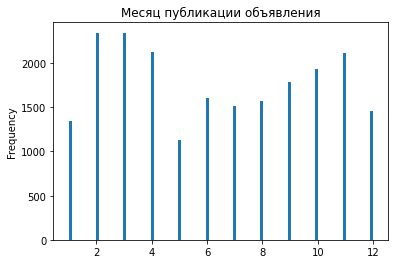

In [184]:
df['month'].plot(kind='hist', title ='Месяц публикации объявления', bins = 100)

Реже всего квартиры выставляют на продажу в январе (январские праздники), мае (майские праздники), декабре (подготовка к январским праздикам))

Наиболее популярные месяцы для продажи квартир - февраль, март, апрель, декабрь (зима-начало весны  - пик продаж квартир). 

Но судя по тематическим сайтам - в это время квартиры редко покупают.

Было бы интересно сравнить именно в какой месяц покупают больше всего квартир. Когда правки буду делать - добавлю это мини исследование)

## Изучим как быстро продавались квартиры

<AxesSubplot:ylabel='Frequency'>

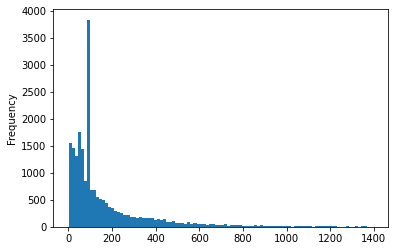

In [185]:
df['days_exposition'].plot(kind='hist', bins = 100) #построили диаграмму

<AxesSubplot:ylabel='Frequency'>

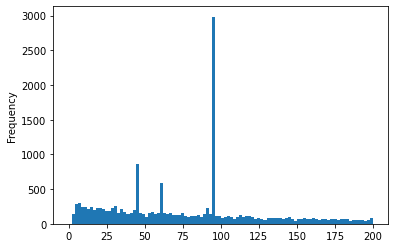

In [186]:
df['days_exposition'].plot(kind='hist', bins = 100, range =(0, 200)) #построили более подробную гистограмму

<AxesSubplot:>

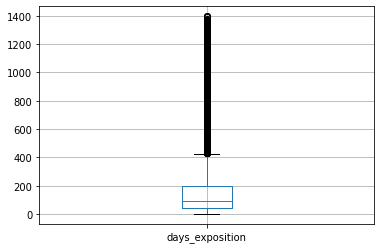

In [187]:
df.loc[:, ['days_exposition']].boxplot() #построили ящик с усами

In [188]:
df['days_exposition'].describe() #нашли медиану (95), среднее(157)

count    21251.000000
mean       168.795774
std        203.045114
min          1.000000
25%         46.000000
50%         95.000000
75%        199.000000
max       1396.000000
Name: days_exposition, dtype: float64

По гистограмме видно, что квартиры висели и по 1000 дней. Это больше 2,5 лет, что очень долго.

Также были квартиры, которые снимали с продажи спустя 1-2 дня

Обычно продажа занимает около 100 дней, это около 3 месяцев. 

Если квартира продается быстрее, чем за 45 дней - это считается быстрой продажей.

Долгой считается продажа, которая затянулась больше, чем на 190 дней



Интересно посмотреть, есть ли зависимость быстроты продажи квартир с другими показателями

<AxesSubplot:>

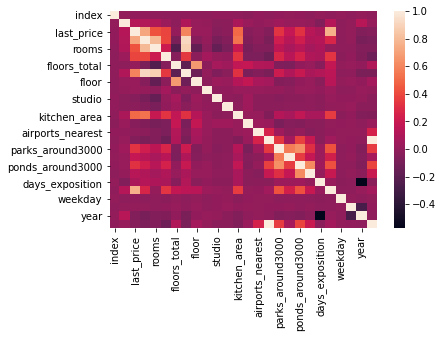

In [189]:
sns.heatmap(df.corr())

Есть сильная зависимость от года выставления объявления

<AxesSubplot:xlabel='days_exposition', ylabel='year'>

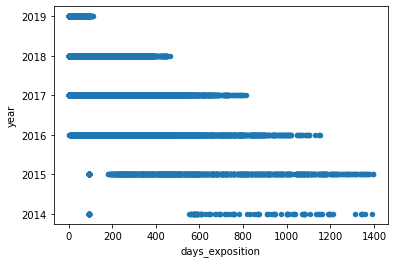

In [190]:
df.plot(kind='scatter', x ='days_exposition', y = 'year')

В основном долго висели объявления 2014-2015 года. Природа таких аномалий мне неизвестна

### Факторы, влияющие на стоимость объекта

In [191]:
df_for_price = df.loc[:, ['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'kind_floor', 'weekday', 'month', 'year']]

Создали новую переменную `df_for_price` в которой только необходимые столбцы по заданию 

In [192]:
df_for_price

,last_price,total_area,living_area,kitchen_area,rooms,kind_floor,weekday,month,year
0,13000000,108.00,51.0,25.00,3,другой,3,3,2019
1,3350000,40.40,18.6,11.00,1,первый,1,12,2018
2,5196000,56.00,34.3,8.30,2,другой,3,8,2015
3,10000000,100.00,32.0,41.00,2,другой,1,6,2018
4,2890000,30.40,14.4,9.10,1,другой,0,9,2018
...,...,...,...,...,...,...,...,...,...
21246,9700000,133.81,73.3,13.83,3,другой,1,3,2017
21247,3100000,59.00,38.0,8.50,3,другой,0,1,2018
21248,2500000,56.70,29.7,9.10,2,первый,6,2,2018
21249,11475000,76.75,30.5,23.30,2,другой,1,3,2017


<AxesSubplot:>

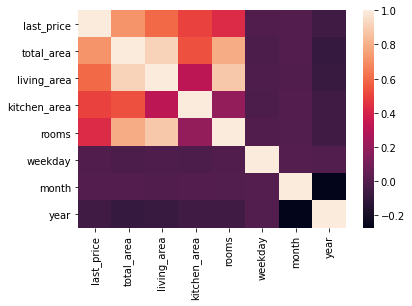

In [193]:
sns.heatmap(df_for_price.corr())

Получился интересный график с плавным переходом от светлых до теманых тонов.

Перечислим по порядку (в порядке уменьшение зависимости) факторы:
1. Общая площадь
2. Жилая площадь
3. Площадь кухни

То есть в основном цена зависит от площади квартиры, что очевидно. Но эту теорию стоило подтвердить

### Средняя цена за один квадратный  метр по городам

In [194]:
popular_city = df['locality_name'].value_counts().head(10) #найдем часто встречающиеся города (возьмем первые 10)

In [195]:
popular_city

Санкт-Петербург      14221
поселок Мурино         517
поселок Шушары         402
Всеволожск             363
поселок Парголово      313
Пушкин                 304
Колпино                278
деревня Кудрово        275
Гатчина                258
Выборг                 215
Name: locality_name, dtype: int64

In [196]:
top_10 =  df.query('locality_name in @popular_city.index') #переменной top_10 данные только по тем городам, которые были в popular city

In [197]:
top_10.groupby('locality_name')['price_of_one_square_m'].mean().sort_values(ascending=False) #вывели среднюю цену за кв м в каждом городе

locality_name
Санкт-Петербург      113675.737818
Пушкин               104282.310156
деревня Кудрово       92556.390837
поселок Парголово     89923.701087
поселок Мурино        85541.945485
поселок Шушары        79155.065848
Колпино               75402.555933
Всеволожск            69064.256551
Гатчина               68764.305866
Выборг                58557.949862
Name: price_of_one_square_m, dtype: float64

Полученная информация подтверждается найденными в интернете данными

Как итог - самые дорогие квартиры в самом Санк-Петербурге  и в городе Пушкин

В этом списке топ-10 локаций самая низкая стоимость квадратного метра Гатчине, Всеволожске и Выборге

### Расстояние до центра в километрах

In [198]:
df_spb = df.query('locality_name == "Санкт-Петербург"') # для анализа взали только СПБ

In [199]:
price_per_km = df_spb['last_price'] // df_spb['cityCenters_km'] #нашли цену за километр в каждой строке

In [200]:
price_per_km 

0         812500.0
2         399692.0
3        1250000.0
6         719545.0
8         360000.0
           ...    
21241     221875.0
21242     916666.0
21243    2367500.0
21246    2425000.0
21249    1147500.0
Length: 14221, dtype: float64

In [201]:
price_per_km.median()  

462500.0

Медианная стоимость одного км равна 465000. Вообще обычно чем ближе к центру, тем квартиры дороже

In [202]:
price_per_km.mean()  #среднее значение не считается

inf

Данное исследование не дает небодимого результата, приведем другое

In [203]:
df_spb['last_price'].corr(df_spb['cityCenters_km']) #сильной зависимости стоимости квартиры от расстояния до центра мы не заметили

-0.3638614929362019

<AxesSubplot:xlabel='cityCenters_km', ylabel='last_price'>

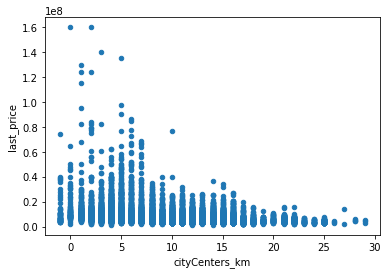

In [204]:
df_spb.plot(kind='scatter', x = 'cityCenters_km', y = 'last_price' )

Дорогие квартиры обычно продаются в пределах 7 км от центра. Чем дальше - тем квартиры дешевле

Саме дорогие квартиры располгаются не более чем в 5 км от центра, что вполне объяснимо

<AxesSubplot:xlabel='cityCenters_km', ylabel='price_of_one_square_m'>

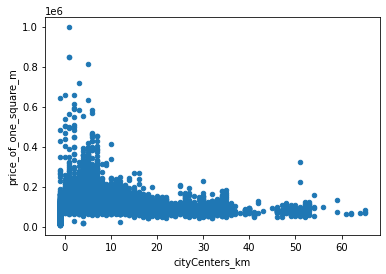

In [207]:
df.plot(kind='scatter', y = 'price_of_one_square_m', x = 'cityCenters_km')

По графику видно, что, чем ближе квртиры к центру - тем выше стоимость одного квадратного метра.

# Вывод

Мы проанализировали рынок недвижимости - это 24 тысячи строк

На рынке больше всего однокомнатных и двухкомнатных квартир. Многокомнатных квартир (4+ комнат) вприницпе мало, поэтому их и меньше продают
 



Аппартаменты составляют только 2% всех квартир. Студии составляют 6%, а квартиры с открытой планировкой - тоже 2%

В объявлениях 1/3 квартир располгаются в Лен области

Цены на квартиры начинаются с 500 тысяч (в Лен области) и могут доходить до 160 млн.  Квартиры в среднем стоят от 3 до 6 млн рублей. Цены на квартиру зависят в основном от месторасположения (дороже всего в самом Питере, ближе к центру) и площади квартиры

Дороже всего квартиры в переделах 5-7 км от центра. Чем дальше располагаются квартиры - тем они дешевле.

Самые дорогие квартиры в самом Санк-Петербурге  и в городе Пушкин. Цена одного квадратного метра в этих городах составляет 113676 и 104282 рублей соответственно


Площадь квартир варьируется от 20 до 250 кв метров.В среднем квартиры имеют площадь от 30 до 70 кв м.
Больше всего квартир с площадью  45 кв м (это 1-2-x комнатные квартиры). 



Жилая площадь варьруется от 10 до 160 квадратных метров. Обычно жилая площадь составляет:
- 17-19 кв м (студии или однокомнатные квартиры)
- 31 кв 2 (двухкомнатные квартиры)
- 47 кв м (трехкомнатные квартиры)


Площадь кухни чаще всего составляет 6, 8 или 10 кв м (скорее всего это общепринятый стандарт).

Реже, но чаще остальных строят квартиры с кухонной площадью в 6,8 и 10 кв м

Стандартная высота потолка - 2,7 кв м. Менее популярны пототолки высотой 2,5м



В Санкт-Петербурге чаше всего строятся здания высотой 5 или 9 этажей.

Только 12% квартир располагаются на первом этаже, 14% на последнем этаже.


Исходя из вышеназванных фактов неудивительно, что чаще всего квартиры продаются с 2,3 и 4 этажа.

Чаще всего в квартирах нет балконов (в 14000), один балкон в 3900 квартир, по два балкона в 2800 квартир


До центра города в среднее растояние до центра - 10-20 км, до аэропорта 10 - 40км


Около квартир чаще всего 1 парк и водоем или их нет вовсе. Если есть парк/водоем, то идти до них в среднем 200-600 метров



Квартиры на продажу обычно выставляют в будние дни. Если говорить о сезонности, то пик - с февраля по май

В среднем квартиры продаются в течении полугода